# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


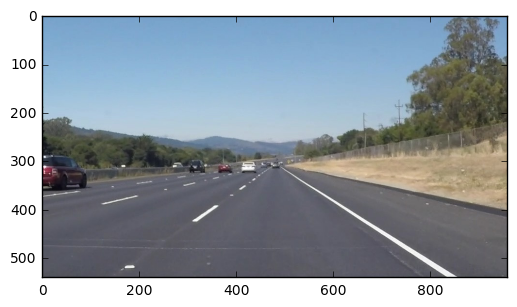

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

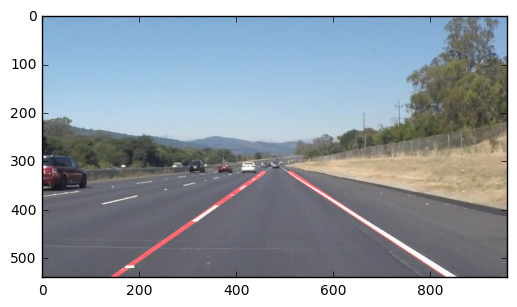

In [3]:
import math

"""define some helpfull variables"""
"""assumption that lane lines have a fix width, you can define an offset to rearrange the masked field of vision
if the car is not driving in the exact middle of the lane, or beeing on a slope etc. Pay attention to lane-control
as reference points may be dependent and the offset should be considered in the control!"""
xsize = image.shape[1]
ysize = image.shape[0]
# offset(+x, +y)
offset = np.array([0 , 0])
xcenter = ((xsize/2)+offset[0])
ycenter = ((ysize/2)+offset[1])
"""polygon mask of interest"""
"""[top-right(x,y) , top-left(x,y) , bottom-left(x,y) , bottom-right(x,y)]"""
vertices = np.array([[(xsize*0.55+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.45+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.05+offset[0], ysize*1+offset[1]),
                          (xsize*0.95+offset[0], ysize*1+offset[1])]],
                        dtype=np.int32)

def grayscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    return gray
    
def gaussian_blur(gray, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    #kernel_size = 5
    gb_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    plt.imshow(gb_gray, cmap='gray')
    return gb_gray

def canny(gb_gray, low_threshold=70, high_threshold=180):
    """Applies the Canny transform"""
    #low_threshold  = 70
    #high_threshold = 180
    edges = cv2.Canny(gb_gray, low_threshold, high_threshold)
    plt.imshow(edges)
    return edges

def region_of_interest(image, edges, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(edges)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[(len(image.shape)-1)]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(edges, mask)
    plt.imshow(masked_image)
    return masked_image


def hough_lines(masked_image, rho=5, theta=np.pi/100, threshold=100, min_line_len=20, max_line_gap=10, color=[255, 0, 0], thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_image = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
    #lines2=cv2.bitwise_and(line_image, lines)
    plt.imshow(lines)
    return lines

    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#    line_image = np.copy(image)*0 # creating a blank to draw lines on
 
#    for line in lines:
 #       for x1,y1,x2,y2 in line:
 #           cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
#    plt.imshow(line_image)
 #   return line_image

def lane_detection(image, lines, color=[255, 0, 0], thickness=2):
    """cv2.HoughLines computes start and endpoints of detected line parts
    e.g. ([xa1,ya1 , xb1,yb1], [xa2,yb2 , xa2,yb2], ...)
    
    use this to define m of a line f(x)=y=mx+c
    
    Assumption1: lane lines are only straight if the camera is straight above them,
    which will only happen for a short time while lane switching. So y-parallel lines can be neglected, if
    lane switching considers some extra logic!
    Assumption2: lane lines are mostly not very steep. So near x-parallel lines will also be neglected
    which may also need further consideration for other driving situations"""
    slopes=np.zeros((len(lines),5)) #slopes=[ [m1 , xa1,ya1,xb1,yb1] , [m2 ...] , ...]
    
    i=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #   y-parallel    x-parallel     lines with lesser of |26°| slope are neglected
            if (x1-x2)!=0 and (y1-y2)!=0 and abs((y1-y2)/(x1-x2))>0.5:
                slopes[i]=(( [((y1-y2)/(x1-x2)), x1,y1,x2,y2] ))
            i=i+1    
    """slopes contains now the slope for each computed Hough Line
    the neglected slopes have a row of zeros, these are deleted in the next step"""
    mask = np.all(slopes == 0, axis=1) #http://stackoverflow.com/questions/22032668/numpy-drop-rows-with-all-nan-or-0-values
    slopes = slopes[~mask]

    """To get one lane-line from the several Hough Lines, it is possible to create an averaged single line for each site
    To not lower the average quality through lines that are probably not detected corrected, relativly extreme slopes are neglected"""
    """To begin with, the slopes are departed into left and right, through their position in the image"""
    """And again, in situations like a turning car, this may cause detection problems, so it has to be considered"""
    midx=xsize/2
    leftslopes=np.zeros((len(slopes),5))
    rightslopes=np.zeros((len(slopes),5))
    i=0
    for lines in slopes:
        if slopes[i][1]<midx or slopes[i][3]<midx:
            leftslopes[i]=slopes[i]
        else:
            rightslopes[i]=slopes[i]
        i=i+1            
    mask = np.all(leftslopes == 0, axis=1)
    leftslopes = leftslopes[~mask]            
    mask = np.all(rightslopes == 0, axis=1)
    rightslopes = rightslopes[~mask]   
    """To determine extreme slopes, each slope is compared to the average-slope
    It was defined that the expected slope will be in the range of |26°;89°|
    If we define that 25% difference is extreme then this is about tan(|16°|)=0,28"""        
    #avg_right=np.mean(rightslopes, axis=0)
    #avg_right=avg_right[0]
    #i=0
    #while i<len(rightslopes):
    #    slope=rightslopes[i][0]
    #    if slope<(avg_right-0,28) or slope>(avg_right+0,28):
    #        rightslopes=np.rightslopes(i,(1), axis=0)
    #    else:
    #        i=i+1
    #avg_left=np.mean(leftslopes, axis=0)
    #avg_left=avg_left[0]
    #i=0
    #while i<len(leftslopes):
    #    slope=leftslopes[i][0]
    #    if slope<(avg_left-0,28) or slope>(avg_leftt+0,28):
    #        leftslopes=np.leftslopes(i,(1), axis=0)
    #    else:
    #        i=i+1
    #could not get it to work "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
    #despite beeing scalars... sorry have to skip it time is running out. But it would be just a small improvement anyway, if at all
    """Now that are extreme slopes erased, the average is computed"""
    avg_left=np.mean(leftslopes, axis=0)
    avg_right=np.mean(rightslopes, axis=0)
    avg_left=avg_left[0]
    avg_right=avg_right[0]
    """To obtain a line the intersection with the y-axis is needed. c=y-mx"""
    """y and x will be the middlepoint of a single line of the Hough Lines"""
    c_left=np.zeros(len(leftslopes))
    i=0
    for m,x1,y1,x2,y2 in leftslopes:
        yi=(y1+y2)/2
        xi=(x1+x2)/2
        c_left[i]=yi-xi*avg_left
        i=i+1
    c_right=np.zeros(len(rightslopes))
    i=0
    for m,x1,y1,x2,y2 in rightslopes:
        yi=(y1+y2)/2
        xi=(x1+x2)/2
        c_right[i]=yi-xi*avg_right
        i=i+1
    """Taking the average of the y-axis intersections to obtain the averaged line"""
    cl_avg=np.mean(c_left)
    cr_avg=np.mean(c_right)

    """Now it is possible to plot a continuous line as lane-line"""
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    #x=(y-c)/m
    yl1=vertices[(0,0,1)]
    xl1=(yl1-cl_avg)/avg_left
    xl1=xl1.astype(int)
    yl2=vertices[(0,2,1)]
    xl2=(yl2-cl_avg)/avg_left
    xl2=xl2.astype(int)
    
    yr1=vertices[(0,0,1)]
    xr1=(yr1-cr_avg)/avg_right
    xr1=xr1.astype(int)
    yr2=vertices[(0,2,1)]
    xr2=(yr2-cr_avg)/avg_right
    xr2=xr2.astype(int)
    points=np.array([[(xl1,yl1,xl2,yl2)],[(xr1,yr1,xr2,yr2)]])
    for line in points:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
    plt.imshow(line_image)
    return line_image

# Python 3 has support for cool math symbols.

def weighted_img(line_image, image, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    lines_edges = cv2.addWeighted(image, α, line_image, β, λ)
    plt.imshow(lines_edges)
    return lines_edges

gray=grayscale(image)
gb_gray=gaussian_blur(gray, kernel_size=5)
edges=canny(gb_gray, low_threshold=70, high_threshold=180)
masked_image=region_of_interest(image, edges, vertices)
lines=hough_lines(masked_image, rho=5, theta=np.pi/100, threshold=110, min_line_len=15, max_line_gap=15, color=[255, 0, 0], thickness=2)

line_image=lane_detection(image, lines, color=[255, 0, 0], thickness=8)
lines_edges=weighted_img(image, line_image, α=1., β=1, λ=10.)

In [192]:
## Test on Images

#Now you should build your pipeline to work on the images in the directory "test_images"  
#**You should make sure your pipeline works well on these images before you try the videos.**

In [21]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

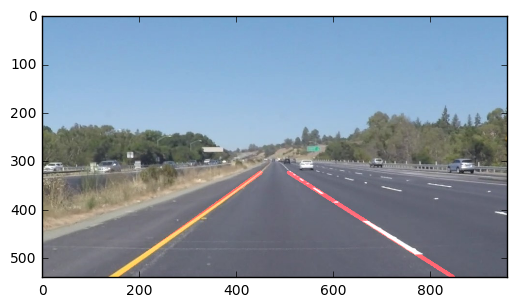

In [227]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
"""define some helpfull variables"""
"""assumption that lane lines have a fix width, you can define an offset to rearrange the masked field of vision
if the car is not driving in the exact middle of the lane, or beeing on a slope etc. Pay attention to lane-control
as reference points may be dependent and the offset should be considered in the control!"""
xsize = image.shape[1]
ysize = image.shape[0]
# offset(+x, +y)
offset = np.array([0 , 0])
xcenter = ((xsize/2)+offset[0])
ycenter = ((ysize/2)+offset[1])
"""polygon mask of interest"""
"""[top-right(x,y) , top-left(x,y) , bottom-left(x,y) , bottom-right(x,y)]"""
vertices = np.array([[(xsize*0.55+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.45+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.05+offset[0], ysize*1+offset[1]),
                          (xsize*0.95+offset[0], ysize*1+offset[1])]],
                        dtype=np.int32)

#reading in images
import os
set_images = os.listdir("test_images/")

names=['detected_solidWhiteCurve.jpg',
 'detected_solidWhiteRight.jpg',
 'detected_solidYellowCurve.jpg',
 'detected_solidYellowCurve2.jpg',
 'detected_solidYellowLeft.jpg',
 'detected_whiteCarLaneSwitch.jpg']
i=0
while i<(len(set_images)-1):
    #image = mpimg.imread('test_images/' , set_images[i])
    #directory is protected, cant disable protection, have to call the images from maindirectory
    image = mpimg.imread(set_images[i])
    gray=grayscale(image)
    gb_gray=gaussian_blur(gray, kernel_size=5)
    edges=canny(gb_gray, low_threshold=70, high_threshold=180)
    masked_image=region_of_interest(image, edges, vertices)
    lines=hough_lines(masked_image, rho=5, theta=np.pi/100, threshold=110, min_line_len=15, max_line_gap=15, color=[255, 0, 0], thickness=2)
    line_image=lane_detection(image, lines, color=[255, 0, 0], thickness=8)
    lines_edges=weighted_img(image, line_image, α=1., β=1, λ=10.)
    plt.savefig(names[i])
    i=i+1
    image = mpimg.imread(set_images[i])


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import cv2
    %matplotlib inline
    """define some helpfull variables"""
    """assumption that lane lines have a fix width, you can define an offset to rearrange the masked field of vision
    if the car is not driving in the exact middle of the lane, or beeing on a slope etc. Pay attention to lane-control
    as reference points may be dependent and the offset should be considered in the control!"""
    xsize = image.shape[1]
    ysize = image.shape[0]
    # offset(+x, +y)
    offset = np.array([0 , 0])
    xcenter = ((xsize/2)+offset[0])
    ycenter = ((ysize/2)+offset[1])
    """polygon mask of interest"""
    """[top-right(x,y) , top-left(x,y) , bottom-left(x,y) , bottom-right(x,y)]"""
    vertices = np.array([[(xsize*0.55+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.45+offset[0], ysize*0.60+offset[1]),
                          (xsize*0.05+offset[0], ysize*1+offset[1]),
                          (xsize*0.95+offset[0], ysize*1+offset[1])]],
                        dtype=np.int32)
    gray=grayscale(image)
    gb_gray=gaussian_blur(gray, kernel_size=5)
    edges=canny(gb_gray, low_threshold=70, high_threshold=180)
    masked_image=region_of_interest(image, edges, vertices)
    lines=hough_lines(masked_image, rho=5, theta=np.pi/100, threshold=110, min_line_len=15, max_line_gap=15, color=[255, 0, 0], thickness=2)
    line_image=lane_detection(image, lines, color=[255, 0, 0], thickness=8)
    lines_edges=weighted_img(image, line_image, α=1., β=1, λ=10.)
    result=lines_edges
    return result

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:23<00:00,  8.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 24.3 s


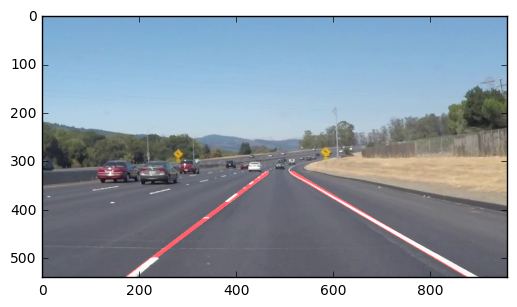

In [6]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [01:13<00:00,  9.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 13s


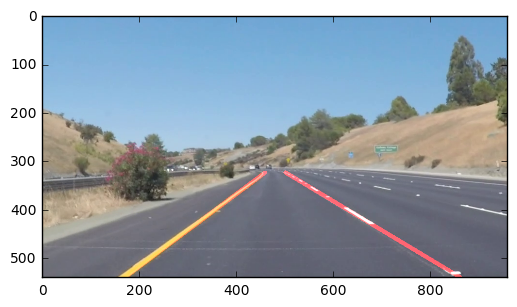

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

=============
how could you imagine making your algorithm better:
----
To avoid wrong detection and therefore screw my average-slope-approach, the field of interest could be improved. After a few images where the generated lines meet general expectes lane-line parameters, the masked area could shrink further more towards the lanes. Not necessarily from the outside, but you could erase the mid section of the road, so that the area of interest is more like 2 pointy triangles.
Furthermore each single line of the Hough lines could be compared to:
- its' neighbours. Most of the time it is much unlikely that the slopes change much between neigghbours
- the mirrored other lane-line to get more reference points
- to expected values for lane lines

The prediction should be also more accurate, if a polynom was used to conect detected lines instead of a line. But at much higher programming effort.
----
how could you imagine making your more robust:
----
Making the lane detection dependent on the past frames. Take an weighted average of the pastly predicted slopes (if they meet the requirements/ are plausible) and the new slope (with more weight for the past ones, but also decreasing weight the further it is in the past). Also check if the new slope is plausible with the other lane, if yes increase the weight of the new slope as it may indicate a curvy road ahead.
---
Where will your current algorithm be likely to fail
---
In rain and night, low sun condition, as lights will reflect much und will generate phantom Houghlines in the masked area.
Also bad maintained tarmac with holes, corroded tarmac, as most likely the lanes will also be badly visible and the contrast of the edgy surface will generate phantom Houghlines.
==========
your thoughts on your lane finding pipeline
----
I would have not guessed that it would be so shaky. To take average points to plot the lines through seems not that good. Better to evaluate the plausibilty of the most distant recognition and take this as reference point for the averaged slope to go through. On the other hand then would be the nearer lane-detection more shaky.
I was completly shocked as i tried the challenge video. This does not work at all.
There I will definitly put some work into, especially with the idea to take the other lane into consideration. Also some more blur and maybe saving previous slopes to reduce the slope spinning. But right now the time is running out, so I hope it is enough to pass at least.

Thank you for reviewing.
Kind regards,
Christoph






















## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:40<00:00,  6.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 41.7 s


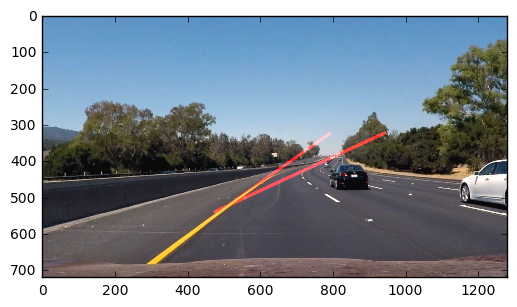

In [10]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))